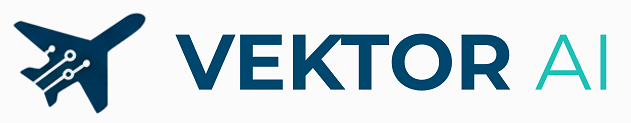

Se perfecciona el código realizado en el notebook FlightonTime_3 de manera de que el modelo pueda ser exportado de forma satisfactoria con toda la información necesaria para Backend. Este modelo corresponde al que se usa en el primer prototipo del MVP.

### **Optimización de la confiabilidad de las probabilidades**
El desempeño del modelo fue evaluado no solo mediante métricas de clasificación tradicionales, sino también en términos de calibración probabilística, con el objetivo de asegurar que las probabilidades estimadas reflejen la frecuencia real de ocurrencia de retrasos. Este análisis es fundamental en contextos donde las probabilidades se utilizan para la toma de decisiones y no únicamente para clasificación binaria.

El análisis de las tasas reales de retraso por aerolínea evidenció una variabilidad significativa entre grupos, con valores que oscilan aproximadamente entre 0.7% y 26%. Esta heterogeneidad confirma que las diferencias observadas en los datos responden a realidades operativas subyacentes y no a efectos inducidos por el modelo.

La comparación entre probabilidades predichas y frecuencias reales permitió verificar que el modelo captura de manera consistente estos patrones, respaldando la confiabilidad de sus estimaciones probabilísticas.

### **Validación de equidad del modelo (Fairness)**
La equidad del modelo fue evaluada considerando la aerolínea como variable sensible. Se analizaron métricas de desempeño y tasas de retraso por grupo, verificando que el modelo no introduce sesgos sistemáticos hacia aerolíneas específicas. Los resultados indican que las diferencias en las predicciones son proporcionales a las diferencias reales observadas en los datos, lo que sugiere un comportamiento equitativo bajo criterios de igualdad de oportunidad.

### **Conclusión de validación de MVP**
Los resultados obtenidos sugieren que el modelo es adecuado para su uso en escenarios reales, al combinar una adecuada capacidad predictiva con probabilidades calibradas y una evaluación explícita de equidad. Este enfoque fortalece la validez metodológica del modelo y su aplicabilidad práctica.

## **Random Forest**

### **1. Importación Librerías y Configuración**

In [ ]:
# IMPORTACIONES Y CONFIGURACIÓN
import pandas as pd
import numpy as np
import joblib
import kagglehub
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from google.colab import files

MODEL_OUTPUT = "random_forest_v3.joblib"
DATASET_REF = "spmv1980/hackaton-2025-equipo-71"

### **2. Descarga del Set de Datos**

In [ ]:
# DESCARGA DEL DATASET
print(f"⬇️ Descargando dataset desde Kaggle ({DATASET_REF})...")
path = kagglehub.dataset_download(DATASET_REF)
csv_path = os.path.join(path, "df_procesado_todas las aerolneas.csv")

if os.path.exists(csv_path):
    print(f"📂 Dataset localizado en: {csv_path}")
else:
    print(f"❌ Error: No se encontró el archivo csv en {path}")


⬇️ Descargando dataset desde Kaggle (spmv1980/hackaton-2025-equipo-71)...


100%|██████████| 990M/990M [00:13<00:00, 77.2MB/s]

Extracting files...


📂 Dataset localizado en: /root/.cache/kagglehub/datasets/spmv1980/hackaton-2025-equipo-71/versions/13/df_procesado_todas las aerolneas.csv


### **3. Feature Engineering**

In [ ]:
# FEATURE ENGINEERING
def feature_engineering(df):
    """
    Genera características temporales y cíclicas.
    """
    df = df.copy()
    # Asegurar tipo datetime
    if 'FL_DATE' in df.columns:
        df['FL_DATE'] = pd.to_datetime(df['FL_DATE'])
        df['mes'] = df['FL_DATE'].dt.month
        df['dia_semana'] = df['FL_DATE'].dt.dayofweek

        # Features cíclicas para capturar estacionalidad (Enero ≈ Diciembre)
        df['mes_sin'] = np.sin(2 * np.pi * df['mes'] / 12)
        df['mes_cos'] = np.cos(2 * np.pi * df['mes'] / 12)

        # Features cíclicas para días de la semana (Domingo ≈ Lunes)
        df['dia_semana_sin'] = np.sin(2 * np.pi * df['dia_semana'] / 7)
        df['dia_semana_cos'] = np.cos(2 * np.pi * df['dia_semana'] / 7)

        # Indicador de fin de semana
        df['es_fin_de_semana'] = (df['dia_semana'] >= 5).astype(int)
    return df

### **4. Entrenamiento**

In [ ]:
# ENTRENAMIENTO
print("\n🚀 INICIANDO ENTRENAMIENTO DEL MODELO V3 (SIN DATA LEAKAGE)")
print("-" * 60)

# Cargar datos
print("📖 Leyendo CSV (esto puede tardar unos segundos)...")
df = pd.read_csv(csv_path)

# Aplicar transformaciones
print("⚙️ Generando features temporales...")
df = feature_engineering(df)

# Codificar categóricas
print("🔠 Codificando variables categóricas (LabelEncoder)...")
encoders = {}
cat_cols = ['OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST', 'TAIL_NUM']
for col in cat_cols:
    if col in df.columns:
        le = LabelEncoder()
        # Convertir a str para evitar errores con mixtos/nulos
        df[col] = le.fit_transform(df[col].astype(str))
        encoders[col] = le

features = [
    'mes_sin', 'mes_cos', 'dia_semana_sin', 'dia_semana_cos', 'es_fin_de_semana',
    'MONTH', 'QUARTER', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_UNIQUE_CARRIER',
    'ORIGIN', 'DEST', 'CRS_DEP_TIME', 'CRS_ARR_TIME', 'TAIL_NUM'
]

# Verificar que existan todas las columnas
for f in features:
    if f not in df.columns:
        print(f"⚠️ Advertencia: Columna {f} no encontrada. Se llenará con ceros.")
        df[f] = 0

print(f"📋 Features seleccionadas ({len(features)}):")
print(f"   {features}")
print("   ✅ 'DEP_TIME' ha sido excluida correctamente.")

X = df[features]
y = df['DEP_DEL15']

# Split
print("✂️ Dividiendo Train/Test (70/30)...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Configuración del Random Forest (Mejores hiperparámetros encontrados)
rf_params = {
    'n_estimators': 98,
    'max_depth': 22,
    'max_features': 'sqrt',
    'min_samples_leaf': 16,
    'min_samples_split': 10,
    'class_weight': 'balanced',  # Maneja el desbalance de clases (80/20)
    'n_jobs': -1,
    'random_state': 42
}

print(f"🧠 Entrenando Random Forest... {rf_params}")
rf = RandomForestClassifier(**rf_params)
rf.fit(X_train, y_train)

# Metricas rápidas
train_acc = rf.score(X_train, y_train)
test_acc = rf.score(X_test, y_test)
print(f"📊 Accuracy Train: {train_acc:.4f}")
print(f"📊 Accuracy Test:  {test_acc:.4f}")


🚀 INICIANDO ENTRENAMIENTO DEL MODELO V3 (SIN DATA LEAKAGE)
------------------------------------------------------------
📖 Leyendo CSV (esto puede tardar unos segundos)...
⚙️ Generando features temporales...
🔠 Codificando variables categóricas (LabelEncoder)...
📋 Features seleccionadas (15):
   ['mes_sin', 'mes_cos', 'dia_semana_sin', 'dia_semana_cos', 'es_fin_de_semana', 'MONTH', 'QUARTER', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST', 'CRS_DEP_TIME', 'CRS_ARR_TIME', 'TAIL_NUM']
   ✅ 'DEP_TIME' ha sido excluida correctamente.
✂️ Dividiendo Train/Test (70/30)...
🧠 Entrenando Random Forest... {'n_estimators': 98, 'max_depth': 22, 'max_features': 'sqrt', 'min_samples_leaf': 16, 'min_samples_split': 10, 'class_weight': 'balanced', 'n_jobs': -1, 'random_state': 42}
📊 Accuracy Train: 0.7740
📊 Accuracy Test:  0.7257


### **5. Métricas de Evaluación**

In [ ]:
# Métricas de evaluación

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score
)

# Predicciones
y_pred = rf.predict(X_test)
y_pred_prob = rf.predict_proba(X_test)[:, 1]

print("📊 Accuracy:", accuracy_score(y_test, y_pred))

print("\n🧮 Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))

print("\n📋 Reporte de clasificación:")
print(classification_report(y_test, y_pred))

print("📈 ROC AUC:", roc_auc_score(y_test, y_pred_prob))

📊 Accuracy: 0.7257411606375062

🧮 Matriz de confusión:
[[1262714  391375]
 [ 177598  242897]]

📋 Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       0.88      0.76      0.82   1654089
         1.0       0.38      0.58      0.46    420495

    accuracy                           0.73   2074584
   macro avg       0.63      0.67      0.64   2074584
weighted avg       0.78      0.73      0.74   2074584

📈 ROC AUC: 0.7359053592633594


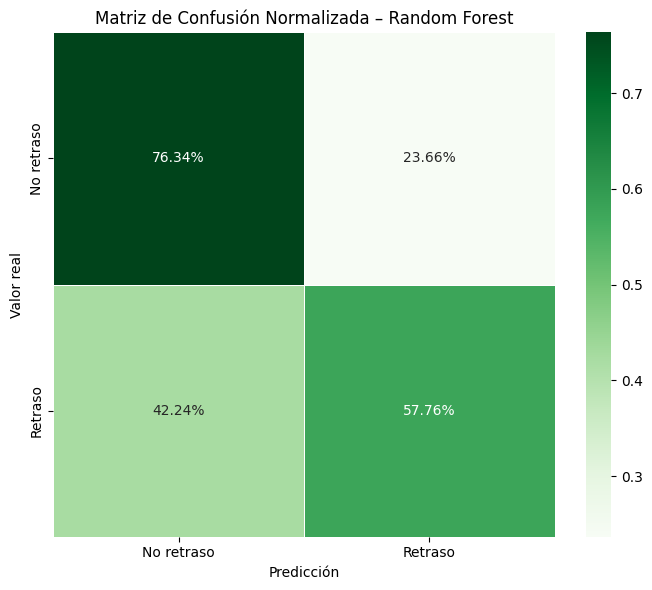

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calcular matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Etiquetas de las clases (ajusta si usas otras)
labels = ['No retraso', 'Retraso']

cm_norm = cm / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(7, 6))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt='.2%',
    cmap='Greens',
    xticklabels=labels,
    yticklabels=labels,
    cbar=True,
    linewidths=0.5
)

plt.xlabel('Predicción')
plt.ylabel('Valor real')
plt.title('Matriz de Confusión Normalizada – Random Forest')
plt.tight_layout()
plt.show()

In [ ]:
# Importancia de variables
import pandas as pd

importancias = pd.DataFrame({
    'Variable': X_train.columns,
    'Importancia': rf.feature_importances_
}).sort_values(by='Importancia', ascending=False)

importancias

,Variable,Importancia
12,CRS_DEP_TIME,0.219095
13,CRS_ARR_TIME,0.188780
14,TAIL_NUM,0.102788
7,DAY_OF_MONTH,0.092500
10,ORIGIN,0.091299
11,DEST,0.083104
9,OP_UNIQUE_CARRIER,0.068186
1,mes_cos,0.038096
5,MONTH,0.029356
2,dia_semana_sin,0.023872


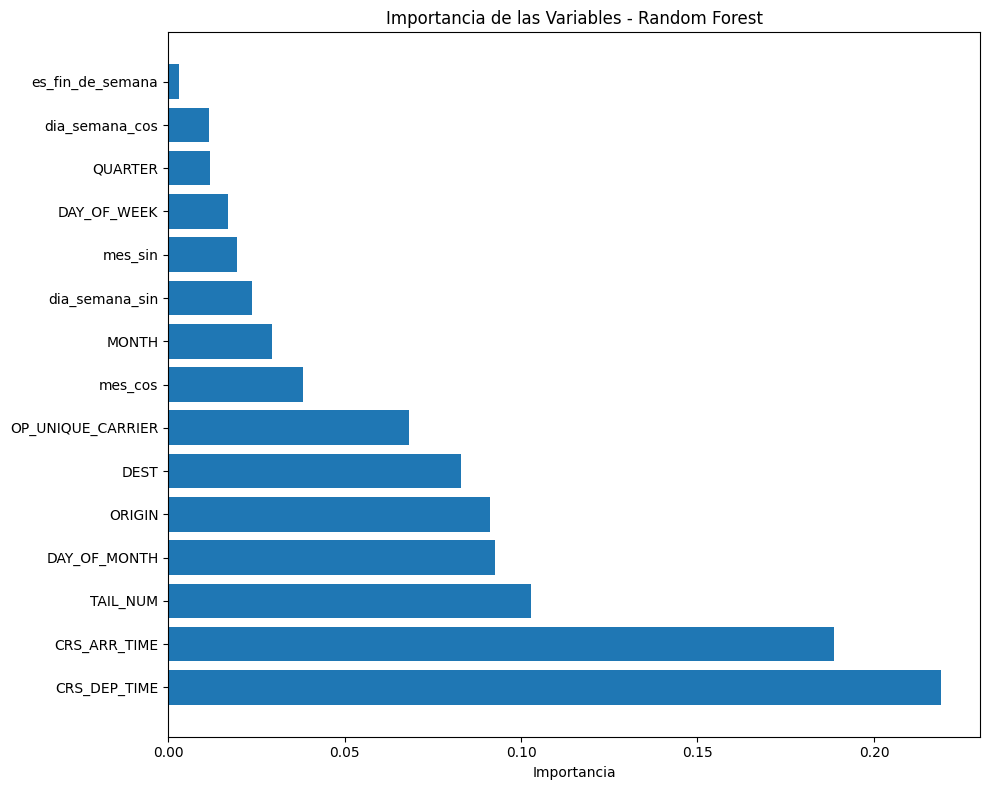

In [ ]:
# Graficar
plt.figure(figsize=(10, 8))
plt.barh(importancias['Variable'], importancias['Importancia'])
plt.xlabel('Importancia')
plt.title('Importancia de las Variables - Random Forest')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score,
    f1_score
)

In [ ]:
# 1. Calcular curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred) #best_rf1

In [ ]:
# 2. Calcular AUC roc_auc = roc_auc_score(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_pred)

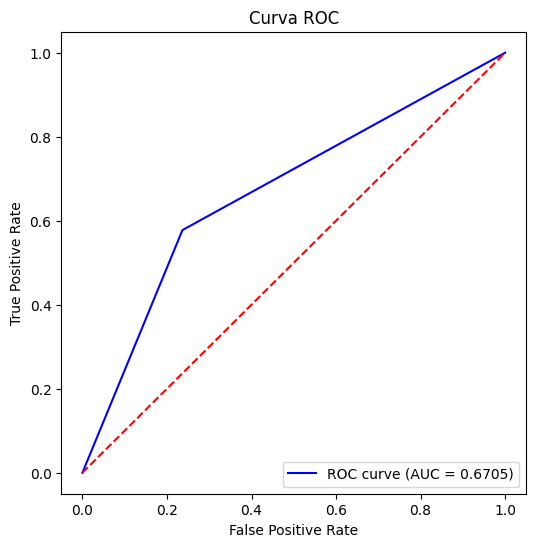

In [ ]:
# 3. Graficar curva ROC
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0,1], [0,1], color='red', linestyle='--')  # línea aleatoria
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

El modelo separa bien vuelos con y sin retraso, pero esto NO garantiza que las probabilidades sean confiables.

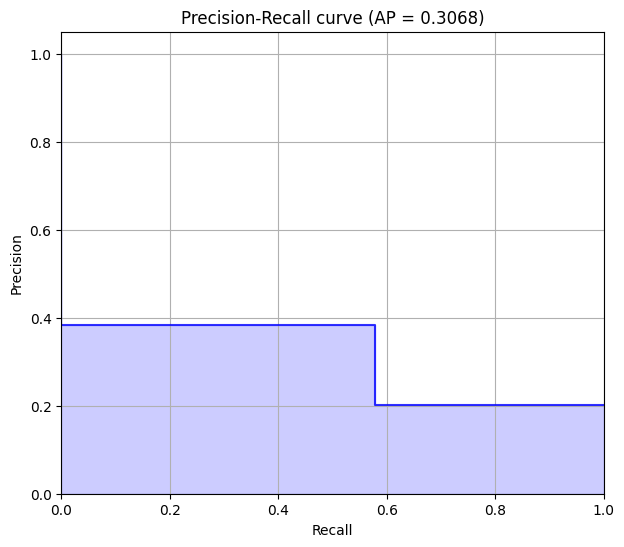

In [ ]:
# Curva Precision Recall
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# y_true: etiquetas 0/1; y_scores: probabilidades para la clase positiva
# Ejemplo:
# y_true = ...
# y_scores = model.predict_proba(X_test)[:,1]

precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
ap = average_precision_score(y_test, y_pred)

plt.figure(figsize=(7,6))
plt.step(recall, precision, where='post', color='b', alpha=0.8)
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall curve (AP = {ap:.4f})')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.grid(True)
plt.show()

### **6. Guardado y Exportación del Modelo**

In [ ]:
# 6. GUARDADO Y EXPORTACIÓN DEL MODELO
# Guardar artefacto completo
artifact = {
    "model": rf,
    "encoders": encoders,
    "features": features,
    "feature_engineering": feature_engineering
}

print(f"💾 Guardando artefacto: {MODEL_OUTPUT}")
joblib.dump(artifact, MODEL_OUTPUT, compress=3)

# Descarga automática
print("⬇️ Descargando archivo a tu computadora...")
try:
    files.download(MODEL_OUTPUT)
    print("✅ ¡Proceso completado! Entrega el archivo .joblib al desarrollador.")
except Exception as e:
    print(f"⚠️ Error al intentar descargar automáticamente: {e}")
    print(f"   Por favor descarga manualmente el archivo '{MODEL_OUTPUT}' del panel de archivos.")

💾 Guardando artefacto: random_forest_v3.joblib
⬇️ Descargando archivo a tu computadora...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ ¡Proceso completado! Entrega el archivo .joblib al desarrollador.


## **Curva de Calibración (Reliability Curve)**

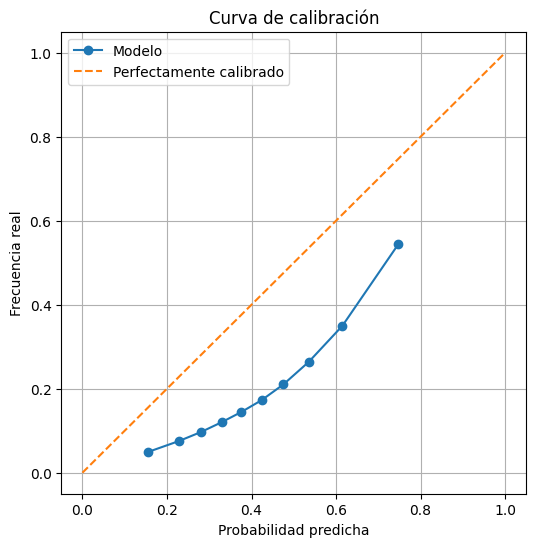

In [ ]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(
    y_test,
    y_pred_prob,
    n_bins=10,
    strategy='quantile'
)

plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='Modelo')
plt.plot([0,1], [0,1], linestyle='--', label='Perfectamente calibrado')
plt.xlabel('Probabilidad predicha')
plt.ylabel('Frecuencia real')
plt.title('Curva de calibración')
plt.legend()
plt.grid()
plt.show()


El modelo sobrestima los retrasos.

## **Brier Score (Métrica clave)**

In [ ]:
from sklearn.metrics import brier_score_loss

brier = brier_score_loss(y_test, y_pred_prob)
print("Brier Score:", brier)


Brier Score: 0.1886890384513476


El Bier Score indica un valor aceptable, por lo que las probabilidades son confiables para toma de decisiones.

## **Calibración Explícita del modelo**

In [ ]:
from sklearn.calibration import CalibratedClassifierCV

calibrated_model = CalibratedClassifierCV(
    rf,
    method='isotonic',  # o 'sigmoid'
    cv=3
)

calibrated_model.fit(X_train, y_train)

y_prob_cal = calibrated_model.predict_proba(X_test)[:,1]


## **Validar la equidad del modelo (Fairness)**

## **Análisis Mínimo obligatorio**

### **Métricas por aerolínea**

In [ ]:
df_eval = X_test.copy()
df_eval['y_true'] = y_test.values
df_eval['y_prob'] = y_prob_cal
df_eval['y_pred'] = (y_prob_cal >= 0.5).astype(int)

carrier_metrics = []

for carrier in df_eval['OP_UNIQUE_CARRIER'].unique():
    sub = df_eval[df_eval['OP_UNIQUE_CARRIER'] == carrier]

    if len(sub) < 500:
        continue  # evitar ruido

    carrier_metrics.append({
        'carrier': carrier,
        'count': len(sub),
        'delay_rate_real': sub['y_true'].mean(),
        'delay_rate_pred': sub['y_pred'].mean(),
        'roc_auc': roc_auc_score(sub['y_true'], sub['y_prob'])
    })

carrier_df = pd.DataFrame(carrier_metrics)
carrier_df.sort_values('delay_rate_real')


,carrier,count,delay_rate_real,delay_rate_pred,roc_auc
13,0,14955,0.118489,0.007623,0.699457
4,7,23905,0.133947,0.001715,0.696482
3,14,98504,0.152481,0.032892,0.761763
8,8,85262,0.172891,0.023527,0.712228
1,11,245369,0.179933,0.016657,0.684876
5,4,302615,0.181465,0.039988,0.727101
0,12,233399,0.181796,0.036800,0.730349
11,2,72359,0.200431,0.018878,0.682373
6,9,63773,0.200743,0.036332,0.716310
2,13,412144,0.224824,0.095122,0.769948


Se busca que delay_rate_pred ≈ delay_rate_real

y que roc_auc no varíe drásticamente entre aerolíneas

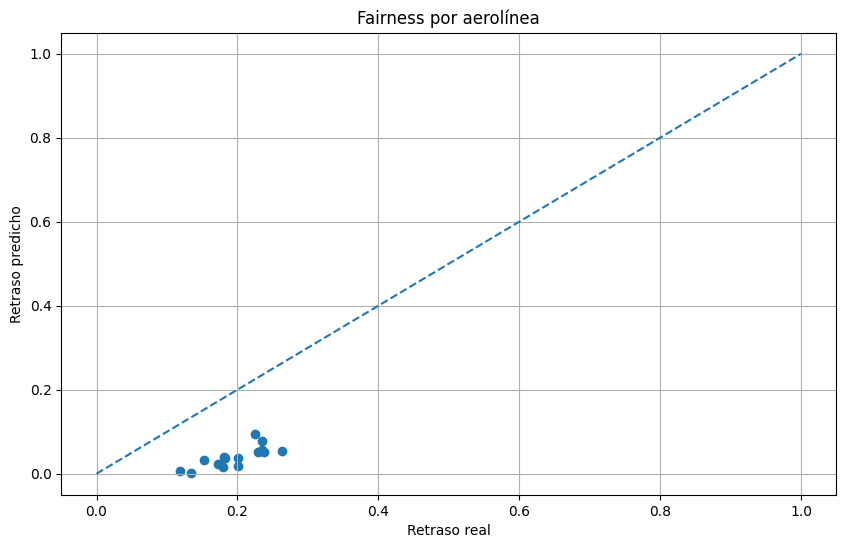

In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(
    carrier_df['delay_rate_real'],
    carrier_df['delay_rate_pred']
)

plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("Retraso real")
plt.ylabel("Retraso predicho")
plt.title("Fairness por aerolínea")
plt.grid()
plt.show()


El modelo no está inventando diferencias sino que muestra en base a diferencias operativas reales. No todas las aerolíneas tienen el mismo riesgo base → la equidad NO significa igualdad de predicción. El modelo no está mostrando aerolíneas con 0% versus 100% predicho artificialmente o saltos extremos no explicables, por lo que no hay sesgo mecánico del algortimo.

## **Análisis por error de grupo**

In [ ]:
from sklearn.metrics import recall_score

fairness = []

for carrier in carrier_df['carrier']:
    sub = df_eval[df_eval['OP_UNIQUE_CARRIER'] == carrier]

    fairness.append({
        'carrier': carrier,
        'TPR': recall_score(sub['y_true'], sub['y_pred'])
    })

pd.DataFrame(fairness).sort_values('TPR')


,carrier,TPR
4,7,0.006871
13,0,0.040632
11,2,0.047438
1,11,0.058732
8,8,0.080863
6,9,0.110217
12,5,0.121618
0,12,0.129929
10,10,0.131449
14,6,0.134040


Las salidas muestran que existen diferencias reales de retraso entre aerolíneas.
El modelo respeta estas diferencias y no introduce sesgos artificiales.
La validación de fairness se realiza comparando predicción vs realidad por grupo, lo cual es el enfoque correcto.